# Applied Natural Language Processing - AT2 - HDInnovators
__Content:__

1. Import packages and create functions
2. Load the dataset
3. Data preparation
4. Sentiment analysis
  
  4.1. RandomForest 
  
  4.2. LSTM

## 1. Import packages and create function

In [1]:
!pip install -q -U keras-tuner

In [2]:
import tensorflow as tf
###### Set up GPU for colab ######
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

2023-05-12 23:37:54.207705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
# data processing
import pandas as pd
import re
import spacy
import string
import numpy as np

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# # drive
# from google.colab import drive
# drive.mount('/content/drive')

# data splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
import keras_tuner as kt

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# tensorflow deep learning 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Flatten, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

# evaluation 
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ignore warnings 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nguyenthao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nguyenthao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nguyenthao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nguyenthao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [33]:
# Create a function to transform valence sentiment labels
def create_sentiment_from_valence(valence):
   if valence < 0.45:
     return 0
   elif valence > 0.55:
     return 2
   else:
     return 1

## 2. Load and explore the dataset

__Load dataset__

In [6]:
# Loading dataset
df = pd.read_csv('../data/data_filtered.csv')

## 3. Data preparation

__Lowercase__

In [7]:
# Convert all data of lyrics to string type.
df['lyrics'] = df['lyrics'].apply(str)

# Convert all string of lyrics to lowercase.
df['lyrics'] = df['lyrics'].str.lower()

 __Tokenize__

In [8]:
# Tokenize text from lyrics. 
df['tokenized'] = df['lyrics'].apply(word_tokenize)

__Remove punctuations__

In [9]:
# All punctuations
punc_marks = list(string.punctuation)
# Remove all punctuations.
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in punc_marks])

__Remove stopwords__

In [10]:
# All stopwords of nltk
stopwords = nltk.corpus.stopwords.words('english')

# Customized list of stop words.
stopwords.extend(["'m", "'s", "'d", "hi", "im", "wa", "n't", "'get", "'ll", "'re", "'ve", "get", "still", "mmm", "ooh", "oooh", "yah", "yeh","mmm", "hmm"])

# Remove the stop words from the dataset and save the result to new column. 
df['cleaned_stopwords'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

__Lemmatize__

In [11]:
# Function to attain part of speech of words.
def determine_wordnet_speech(word_tag):
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Add part of speech tags and save the result to new column.
df['pos_tags'] = df['cleaned_stopwords'].apply(nltk.tag.pos_tag)

# Function to get part of speech in WordNet format.
df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, determine_wordnet_speech(pos_tag)) for (word, pos_tag) in x])

# Lemmatize words and save the result to new column.
word_lemmatizer = WordNetLemmatizer()
df['lyrics_lemmatized'] = df['pos_tags'].apply(lambda x: [word_lemmatizer.lemmatize(word, tag) for word, tag in x])

# Convert list to string datatype. 
df['lyrics_cleaned'] = [' '.join(map(str,l)) for l in df['lyrics_lemmatized']]

# Check few rows.
df.head(3)

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized,lyrics_cleaned
0,13923,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p...","[(cold, a), (chamber, n), (smoke, v), (kush, n...","[cold, chamber, smoke, kush, gettin, high, pla...",cold chamber smoke kush gettin high plane swan...
1,14958,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b...","[(public, a), (service, n), (announcement, n),...","[public, service, announcement, weezy, baby, b...",public service announcement weezy baby best ra...
2,15045,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,...","[(got, v), (ta, a), (rapper, n), (today, n), (...","[get, ta, rapper, today, forget, fuck, smokin,...",get ta rapper today forget fuck smokin brain c...


__Encode label__

In [12]:
# Transform valence to sentiment labels
df['sentiment'] = df['valence'].apply(create_sentiment_from_valence)

__Data splitting__

In [13]:
# Extract labels 
y = df['sentiment']
# Extract independent variables
X = df['lyrics_cleaned']
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)
# Create 3 cv for cross-validation 
cv = StratifiedKFold(n_splits=3, random_state=8, shuffle=True).split(X_train, y_train)

## 4. Sentiment analysis 

### 4.1 RandomForest

__Vectorization__

In [14]:
# Instantiate CountVectorizer
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.2, max_df=0.7, max_features=100)
# Learn a vocabulary dictionary of all tokens in the training set.
vectorizer.fit(X_train)
# Transform training set and testing set to document-term matrix.
X_train_count_vectorized = vectorizer.transform(X_train)
X_test_count_vectorized = vectorizer.transform(X_test)

In [15]:
# Instantiate TfidfTransformer
tfidf_transformer = TfidfTransformer()
# Learn vocabulary and idf from training set.
tfidf_transformer.fit(X_train_count_vectorized)
# Transform a train and set count matrix to a tf-idf representation.
X_train_tfidf = tfidf_transformer.transform(X_train_count_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_count_vectorized)

__Hyperparameter tuning (Grid search)__

In [16]:
# Train a default RandomForest to get average max_depth 
rf1 = RandomForestClassifier(random_state=8, n_estimators=50).fit(X_train_tfidf, y_train)

In [17]:
np.mean([estimator.tree_.max_depth for estimator in rf1.estimators_])

54.14

In [18]:
# Create a search space
hyperparams_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [40, 55, 60],
    'min_samples_split': [2, 4, 8]
    }
hyperparams_grid

{'n_estimators': [50, 100, 150],
 'max_depth': [40, 55, 60],
 'min_samples_split': [2, 4, 8]}

In [18]:
# GridSearch with 3 fold cross-validation
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=8), hyperparams_grid, cv=3, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=40, min_samples_split=2, n_estimators=50; total time=   1.9s
[CV] END .max_depth=40, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END .max_depth=40, min_samples_split=2, n_estimators=50; total time=   2.0s
[CV] END max_depth=40, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=40, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=40, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=40, min_samples_split=2, n_estimators=150; total time=   6.8s
[CV] END max_depth=40, min_samples_split=2, n_estimators=150; total time=   5.9s
[CV] END max_depth=40, min_samples_split=2, n_estimators=150; total time=   6.8s
[CV] END .max_depth=40, min_samples_split=4, n_estimators=50; total time=   1.9s
[CV] END .max_depth=40, min_samples_split=4, n_estimators=50; total time=   1.9s
[CV] END .max_depth=40, min_samples_split=4, n_e

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=8),
             param_grid={'max_depth': [40, 55, 60],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [19]:
# Get the best set of hyperparameters
best_params = grid_search_rf.best_params_
best_params

{'max_depth': 55, 'min_samples_split': 8, 'n_estimators': 150}

In [20]:
# Get the best validation score
grid_search_rf.best_score_

0.544696330148704

__Assessment on test set__

In [21]:
# Train Random Forest model with the best hyperparameter found 
rf_best = RandomForestClassifier(random_state=8, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], n_estimators=best_params['n_estimators']).fit(X_train_tfidf, y_train)

In [21]:
# Predict sentiment of testing set 
y_test_preds = rf_best.predict(X_test_tfidf)

In [22]:
# Accuracy on testing set
accuracy_score(y_test_preds, y_test)

0.547245409015025

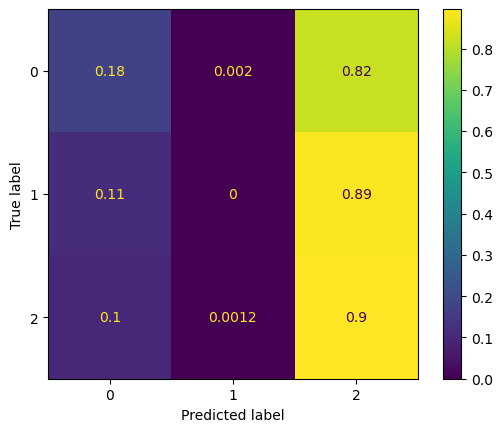

In [23]:
# Confusion matrix on testing set
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, normalize = 'true')

### 5.2 LTSM

__Split training set into another training set and validation set__

In [26]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, random_state=42, stratify = y_train)

__Vectorization__

In [27]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()

# Create a dict of word and index from the list of sentences. Required before texts_to_sequences
word_tokenizer.fit_on_texts(X_train_2)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

29711

In [28]:
# Pad sequences
longest_train_lyrics = max(X_train_2, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train_lyrics))

# texts_to_sequences: Transforms each text in texts to a sequence of integers (integers = index of word by fit_on_texts)
padded_train_lyrics = pad_sequences(
    word_tokenizer.texts_to_sequences(X_train_2),
    length_long_sentence, 
    padding='post'
)

padded_val_lyrics = pad_sequences(
    word_tokenizer.texts_to_sequences(X_val),
    length_long_sentence, 
    padding='post'
)

padded_test_lyrics = pad_sequences(
    word_tokenizer.texts_to_sequences(X_test),
    length_long_sentence, 
    padding='post'
)

__RandomSearch Hyperparameter Tuning__

In [40]:
# convert a vector of probabilities to a label (i.e [0.1, 0.4, 0.5] is converted to label 2 because label 2 has the highest prob)
def convert_probs_to_labels(prediction):
    prediction2 = []
    for i in prediction:
        max_value = max(i)
        prediction2.append(list(i).index(max_value))

    return prediction2

In [18]:
# Create class that is used to tune hyperparameter
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
      with tf.device(device_name):
        model = Sequential()
        # embedding
        hp_vector_size = hp.Int('vector_size', 
                                min_value=100, 
                                max_value=200, 
                                step=50)
        model.add(
            Embedding(input_dim=vocab_length,
                      output_dim=hp_vector_size,
                      input_length=length_long_sentence))

        # first lstm
        hp_lstm_units1 = hp.Int('lstm_units1', 
                                min_value=32, 
                                max_value=128, 
                                step=32)
        model.add(LSTM(hp_lstm_units1, return_sequences=True, kernel_initializer="glorot_uniform"))

        # drop out
        hp_dropout_rate = hp.Float('dropout_rate', 
                                  min_value=0.0, 
                                  max_value=0.4, 
                                  step=0.1)
        model.add(Dropout(hp_dropout_rate))

        # second lstm
        hp_lstm_units2 = hp.Int('lstm_units2', 
                                min_value=32, 
                                max_value=128, 
                                step=32)
        model.add(LSTM(hp_lstm_units2, kernel_regularizer=regularizers.l2(0.01), kernel_initializer="glorot_uniform"))

        # dense layer
        model.add(Dense(3,activation='softmax'))
        
        # compile
        hp_learning_rate = hp.Choice('learning_rate', 
                                    values=[1e-3, 1e-4])
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # tune batch-size
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256, 512]),
            **kwargs,
        )

In [20]:
# Random search the best hyperparameters 20 times to get highest val_accuracy
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective=kt.Objective("val_accuracy", direction="max"),
    max_trials=20,
    # overwrite=True,
    project_name="tune_hypermodel",
    seed=42
)

In [21]:
# Random search 
tuner.search(padded_train_lyrics, 
             y_train_2, 
             verbose = 2,
             epochs=40,
             validation_data=(padded_val_lyrics, y_val)
            #  callbacks=[stop_early]       
             )

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 20 Complete [00h 03m 26s]
val_accuracy: 0.5458592772483826

Best val_accuracy So Far: 0.5463045239448547
Total elapsed time: 00h 31m 26s


In [22]:
# Best hyperparameters 
print(best_hps.get('vector_size'))
print(best_hps.get('lstm_units1'))
print(best_hps.get('dropout_rate'))
print(best_hps.get('lstm_units2'))
print(best_hps.get('learning_rate'))
print(best_hps.get('batch_size'))

150
128
0.0
128
0.001
512


In [24]:
# Train a new LSTM model with the best hyperparaters
model_best = tuner.hypermodel.build(best_hps)
history = model_best.fit(padded_train_lyrics, y_train_2, epochs=100, batch_size=best_hps.get('batch_size'), validation_data=(padded_val_lyrics, y_val))

Epoch 1/100
14/14 [==============================] - 8s 293ms/step - loss: 2.7105 - accuracy: 0.5274 - val_loss: 2.2885 - val_accuracy: 0.5459
Epoch 2/100
14/14 [==============================] - 4s 261ms/step - loss: 2.0416 - accuracy: 0.5456 - val_loss: 1.7661 - val_accuracy: 0.5459
Epoch 3/100
14/14 [==============================] - 3s 217ms/step - loss: 1.6076 - accuracy: 0.5456 - val_loss: 1.4328 - val_accuracy: 0.5459
Epoch 4/100
14/14 [==============================] - 3s 217ms/step - loss: 1.3347 - accuracy: 0.5456 - val_loss: 1.2268 - val_accuracy: 0.5459
Epoch 5/100
14/14 [==============================] - 3s 222ms/step - loss: 1.1667 - accuracy: 0.5456 - val_loss: 1.1027 - val_accuracy: 0.5459
Epoch 6/100
14/14 [==============================] - 4s 263ms/step - loss: 1.0694 - accuracy: 0.5456 - val_loss: 1.0335 - val_accuracy: 0.5459
Epoch 7/100
14/14 [==============================] - 3s 201ms/step - loss: 1.0170 - accuracy: 0.5456 - val_loss: 0.9966 - val_accuracy: 0.5459

In [25]:
# Find the optimal epoch to get the highest val_accuracy
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [26]:
# Train a new LSTM model with the optimal epoch
model_best_epoch = tuner.hypermodel.build(best_hps)
model_best_epoch.fit(padded_train_lyrics, y_train_2, epochs=best_epoch, batch_size=best_hps.get('batch_size'))

14/14 [==============================] - 6s 191ms/step - loss: 2.6988 - accuracy: 0.5301


In [27]:
# Accuracy on testing set
accuracy_best_epoch = model_best_epoch.evaluate(padded_test_lyrics, y_test)
accuracy_best_epoch

94/94 [==============================] - 2s 10ms/step - loss: 2.2727 - accuracy: 0.5459


[2.27274751663208, 0.5459098219871521]

__Glove embedding__

glove.6B.100d.txt can be downloaded here: https://drive.google.com/file/d/10Vo74kbAj-xXWEg00o184OIu5tj4LtwH/view?usp=share_link

In [29]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('../data/glove.6B.100d.txt', encoding='utf-8') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [30]:
# Create a Glove word embedding
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.2687    ,  0.81708002,  0.69896001, ..., -0.40110001,
         0.74656999,  0.31121999],
       [ 0.19073001,  0.56863999,  0.72026998, ..., -0.33460999,
         0.044349  ,  0.57541001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.41383001, -0.063647  ,  0.34494001, ..., -0.20672999,
         0.22294   , -0.56507999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [34]:
# Create new sequential model 
model_glove = Sequential()
# add embedding layer
model_glove.add(
    Embedding(input_dim=embedding_matrix.shape[0],
              output_dim=embedding_matrix.shape[1],
              weights = [embedding_matrix],
              input_length=length_long_sentence))

# add first lstm layer
model_glove.add(LSTM(128, return_sequences=True, kernel_initializer='glorot_uniform'))

# add drop out layer
model_glove.add(Dropout(0.1))

# add second lstm layer
model_glove.add(LSTM(128, kernel_initializer='glorot_uniform'))


# add dense layer
model_glove.add(Dense(3,activation='softmax'))

# compile
model_glove.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2023-05-12 23:57:59.211767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-12 23:57:59.215045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-12 23:57:59.216747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [36]:
# Train a new LSTM model 
model_glove.fit(padded_train_lyrics, y_train_2, epochs=19, batch_size = 512, validation_data = (padded_val_lyrics, y_val))

Epoch 1/19
14/14 [==============================] - 33s 2s/step - loss: 0.9547 - accuracy: 0.5456 - val_loss: 0.9539 - val_accuracy: 0.5459
Epoch 2/19
14/14 [==============================] - 55s 4s/step - loss: 0.9537 - accuracy: 0.5456 - val_loss: 0.9539 - val_accuracy: 0.5459
Epoch 3/19
14/14 [==============================] - 33s 2s/step - loss: 0.9541 - accuracy: 0.5456 - val_loss: 0.9545 - val_accuracy: 0.5459
Epoch 4/19
14/14 [==============================] - 33s 2s/step - loss: 0.9542 - accuracy: 0.5456 - val_loss: 0.9547 - val_accuracy: 0.5459
Epoch 5/19
14/14 [==============================] - 34s 2s/step - loss: 0.9546 - accuracy: 0.5456 - val_loss: 0.9541 - val_accuracy: 0.5459
Epoch 6/19
14/14 [==============================] - 33s 2s/step - loss: 0.9535 - accuracy: 0.5456 - val_loss: 0.9556 - val_accuracy: 0.5459
Epoch 7/19
14/14 [==============================] - 30s 2s/step - loss: 0.9533 - accuracy: 0.5456 - val_loss: 0.9542 - val_accuracy: 0.5459
Epoch 8/19
14/14 [==

In [38]:
# Accuracy on testing set
accuracy_glove = model_glove.evaluate(padded_test_lyrics, y_test)

94/94 [==============================] - 8s 89ms/step - loss: 0.9549 - accuracy: 0.5462


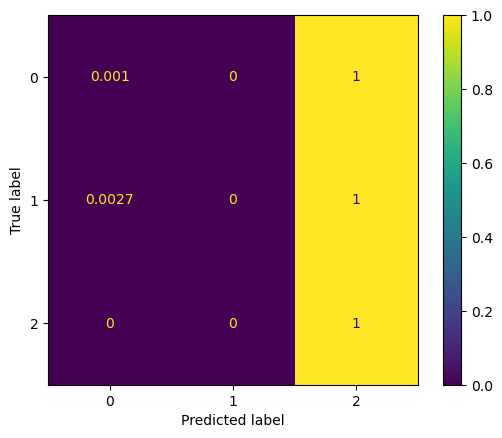

In [42]:
# Predict testing set and get predicted labels
y_test_preds_lstm = convert_probs_to_labels(model_glove.predict(padded_test_lyrics))
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds_lstm, normalize = 'true')